In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
from sklearn.metrics import mean_squared_error

#### Load in data and analyse stationarity / ACF / PCF plots for first person

In [2]:
df = pd.read_csv('data/data_arima.csv')

            mood
time            
2014-02-17   NaN
2014-02-18   NaN
2014-02-19   NaN
2014-02-20   NaN
2014-02-21   NaN
...          ...
2014-05-01   8.0
2014-05-02   7.6
2014-05-03   8.0
2014-05-04   8.0
2014-05-05   NaN

[78 rows x 1 columns]


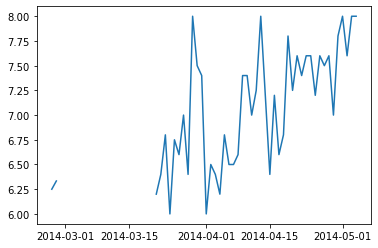

In [3]:
def getPersonMoodArimaSet(person):
    
    # Get mood and set time as index
    mood = df.loc[df["id"] == person][["mood", "time"]]
    mood.set_index(pd.DatetimeIndex(pd.to_datetime(mood.time)), inplace = True)
    mood.drop('time',axis=1,inplace=True)

    # Arima needs a full date range, so fill missing dates
    full_time_range = pd.date_range(mood.index.min(), mood.index.max())
    mood.reindex(full_time_range)
    mood = mood.asfreq('d') # necessary for arima
    
    return mood

mood = getPersonMoodArimaSet("AS14.01")
print(mood)
plt.plot(mood)

#### Stationarity check.

In [4]:
mood_dropna = mood.dropna() ## drop na's because adfuller cannot handle nans
result = adfuller(mood_dropna)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -3.5182590351214746
p-value: 0.007530360619884317
Critical Values:
	1%: -3.5812576580093696
	5%: -2.9267849124681518
	10%: -2.6015409829867675


Okay so this is weird because it should be stationary when p value < 0.05 and critical values reasonably close to ADF statistic (according to https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7). 

However, these values seems to be okay, but the mood for this person is clearly NOT stationary -- there is clearly an upwards trend.

It's not caused by the missing days in between the start and the end:

In [7]:
mood_cutoff = mood.iloc[32:-1] ## drop everything before streak
print(mood_cutoff)

            mood
time            
2014-03-21  6.20
2014-03-22  6.40
2014-03-23  6.80
2014-03-24  6.00
2014-03-25  6.75
2014-03-26  6.60
2014-03-27  7.00
2014-03-28  6.40
2014-03-29  8.00
2014-03-30  7.50
2014-03-31  7.40
2014-04-01  6.00
2014-04-02  6.50
2014-04-03  6.40
2014-04-04  6.20
2014-04-05  6.80
2014-04-06  6.50
2014-04-07  6.50
2014-04-08  6.60
2014-04-09  7.40
2014-04-10  7.40
2014-04-11  7.00
2014-04-12  7.25
2014-04-13  8.00
2014-04-14  7.20
2014-04-15  6.40
2014-04-16  7.20
2014-04-17  6.60
2014-04-18  6.80
2014-04-19  7.80
2014-04-20  7.25
2014-04-21  7.60
2014-04-22  7.40
2014-04-23  7.60
2014-04-24  7.60
2014-04-25  7.20
2014-04-26  7.60
2014-04-27  7.50
2014-04-28  7.60
2014-04-29  7.00
2014-04-30  7.80
2014-05-01  8.00
2014-05-02  7.60
2014-05-03  8.00
2014-05-04  8.00


In [8]:
result = adfuller(mood_cutoff)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -3.6796223894258437
p-value: 0.004409086719118722
Critical Values:
	1%: -3.5885733964124715
	5%: -2.929885661157025
	10%: -2.6031845661157025


#### ACF / PACF analysis

This can only be done when the time series is stationary. According to the adfuller test, the time series is stationary so we will do ACF / PACF to obtain p,q,d.

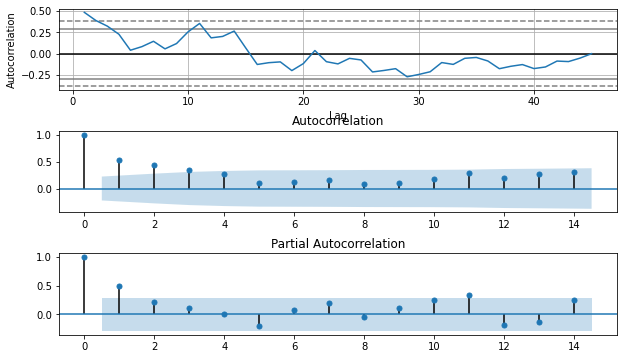

In [9]:
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(10,6))
fig.subplots_adjust(hspace=0.5)

# ACF
autocorrelation_plot(mood_cutoff, ax=ax1) # pandas acf: cannot handle NaN
plot_acf(mood, lags=14, alpha=0.05, use_vlines = True, ax=ax2, missing="drop") # statsmodel acf

# PACF
plot_pacf(mood_cutoff, lags=14, alpha=0.05, use_vlines = True, ax=ax3) # statsmodel acf: cannot handle NaN
plt.show()

Arima try-out

In [10]:
p = 1 # found by acf
d = 0 # no differencing required because already stationary...  (apparantly?)
q = 1 # found by pacf

warnings.filterwarnings("ignore")

                               SARIMAX Results                                
Dep. Variable:                   mood   No. Observations:                   78
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -32.952
Date:                Sun, 11 Apr 2021   AIC                             73.903
Time:                        09:01:09   BIC                             83.330
Sample:                    02-17-2014   HQIC                            77.677
                         - 05-05-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9480      0.369     18.809      0.000       6.224       7.672
ar.L1          0.9302      0.110      8.488      0.000       0.715       1.145
ma.L1         -0.5560      0.234     -2.373      0.0

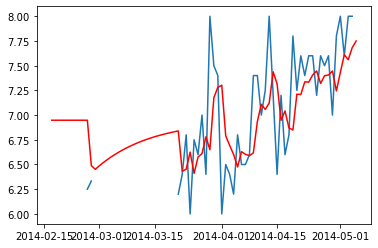

In [11]:
model = ARIMA(mood, order=(p,d,q))
model_fit = model.fit()
print(model_fit.summary())
plt.plot(mood)
plt.plot(model_fit.fittedvalues, color='red')

Use ARIMA to train and test on unforeseen data. We are gonna check the following sets:
- full range, i.e with long gap of NaNs
- cutoff range, i.e without the long gap and without the first 2 values
- dropna, i.e all the non-NaNs

In [12]:
perc_train = 0.8

Test MSE: 0.6544483598207276 	for 1, 0 and 1


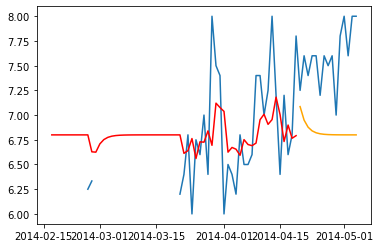

In [13]:
def get_train_set_set(data, perc_train = perc_train):
    
    # Make training and test set
    train_size = int(len(data) * perc_train) 
    
    return data[0:train_size], data[train_size:].dropna()

def perform_ARIMA(data, pdq_order, perc_train = perc_train):
    
    # Get train and test set
    train, test = get_train_set_set(data, perc_train)

    # Train the model
    model = ARIMA(train, order=pdq_order)
    model_fit = model.fit()

    # Forecast and check accuracy
    forecast = model_fit.forecast(len(test))
    mse = mean_squared_error(test, forecast)
    print(f'Test MSE: {mse} \tfor {pdq_order[0]}, {pdq_order[1]} and {pdq_order[2]}')

    # Show observed values, fitted values, and forecasted values
    plt.plot(data)
    plt.plot(model_fit.fittedvalues, color='red') 
    plt.plot(test.index, forecast, color='orange')
    plt.show()
    
perform_ARIMA(mood, (p,d,q))

Test MSE: 0.4960313640274113 	for 1, 0 and 1


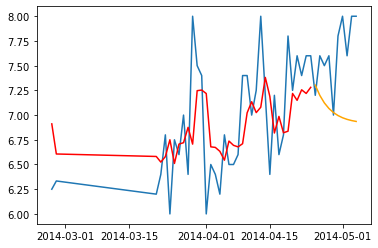

In [14]:
perform_ARIMA(mood_dropna, (p,d,q))

Test MSE: 0.5634167565931091 	for 1, 0 and 1


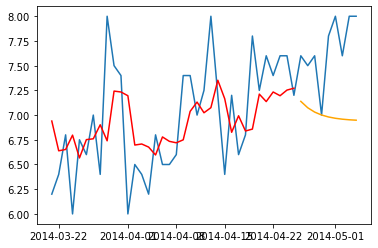

In [15]:
perform_ARIMA(mood_cutoff, (p,d,q))

They are not great. The dropna seems the best though.

Try different p,d,q values because it does not work well with the theoretically obtaines values (1,0,1)

In [16]:
def do_experiment_ARIMA_find_pdq_values(data, p_values, d_values, q_values, doPrint = True):
    results = []
    
    # Get train and test set
    train, test = get_train_set_set(data, perc_train)
    
    # Try out all p, d, q values
    for p in p_values:
        for d in d_values:
            for q in q_values:

                # Train the model
                model = ARIMA(train, order=(p, d, q))
                model_fit = model.fit()

                # Forecast and check accuracy
                forecast = model_fit.forecast(len(test))
                mse = mean_squared_error(test, forecast)
                
                if doPrint:
                    print(f'Test MSE: {mse} \t\t\tfor {p}, {d} and {q}')
                
                # Save results
                results.append([p,d,q,mse])
            
                # Show observed values, fitted values, and forecasted values
                if doPrint:
                    plt.plot(data)
                    plt.plot(model_fit.fittedvalues, color='red')  
                    plt.plot(test.index, forecast, color='orange')
                    plt.show()

    return pd.DataFrame(results, columns=["p", "d", "q", "mse"])
    
p_values = [0,1,2,3]
d_values = [0,1,2]
q_values = [0,1,2]

Test MSE: 0.6659477458520975 			for 0, 0 and 0


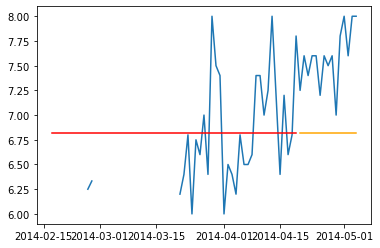

Test MSE: 0.6599634571589753 			for 0, 0 and 1


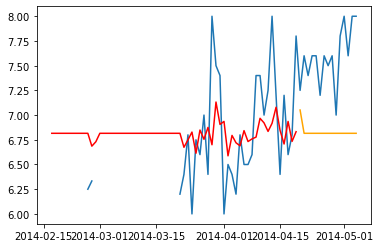

Test MSE: 0.6551077618888148 			for 0, 0 and 2


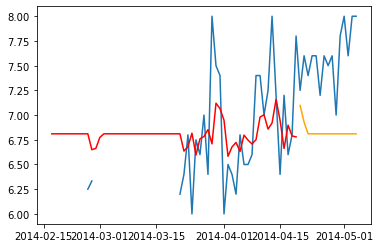

Test MSE: 0.12749999999999959 			for 0, 1 and 0


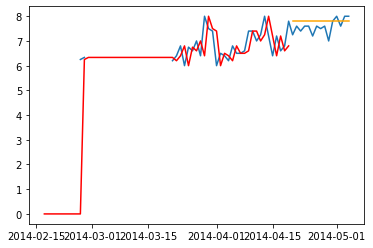

Test MSE: 0.312936279881885 			for 0, 1 and 1


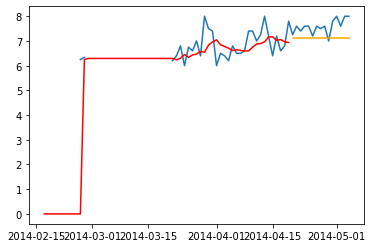

Test MSE: 0.3510911746321484 			for 0, 1 and 2


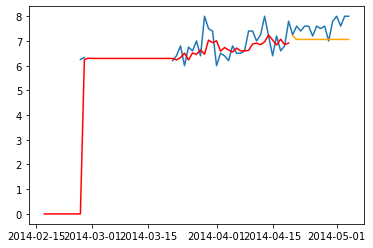

Test MSE: 84.86750000000038 			for 0, 2 and 0


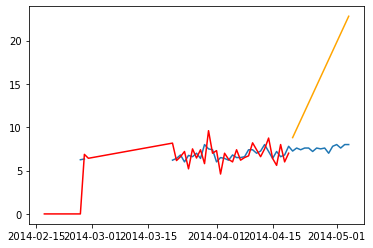

Test MSE: 0.2658776642272948 			for 0, 2 and 1


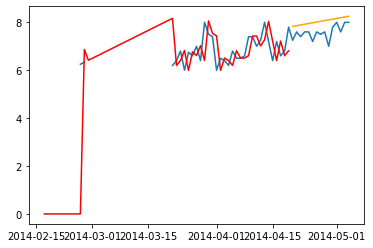

Test MSE: 0.14793820080570644 			for 0, 2 and 2


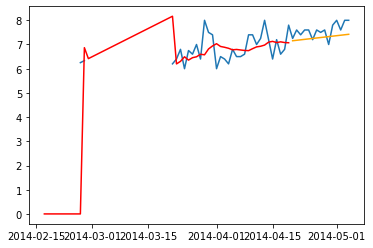

Test MSE: 0.6555128264376139 			for 1, 0 and 0


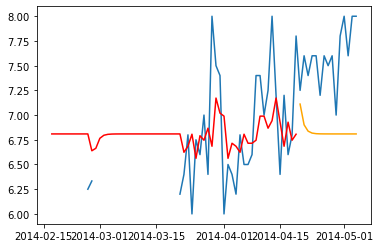

Test MSE: 0.6544483598207276 			for 1, 0 and 1


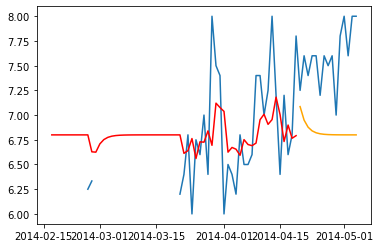

Test MSE: 0.6578351263264517 			for 1, 0 and 2


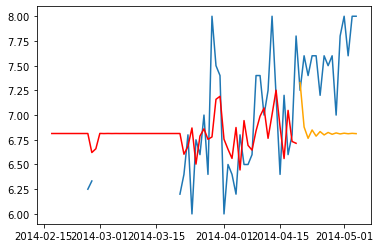

Test MSE: 0.08220007583533341 			for 1, 1 and 0


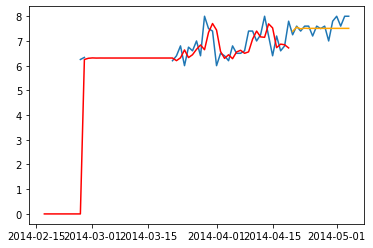

Test MSE: 0.3655243259015169 			for 1, 1 and 1


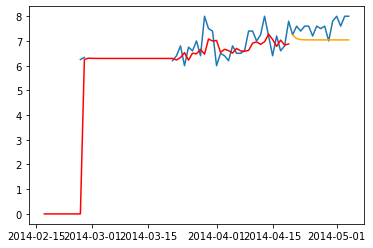

Test MSE: 0.3770542874323914 			for 1, 1 and 2


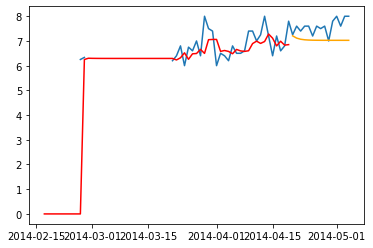

Test MSE: 39.06455369632145 			for 1, 2 and 0


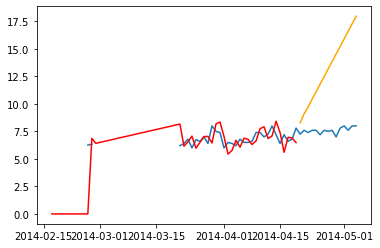

Test MSE: 0.07246922053739314 			for 1, 2 and 1


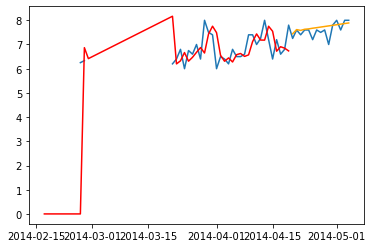

Test MSE: 0.11806996413353604 			for 1, 2 and 2


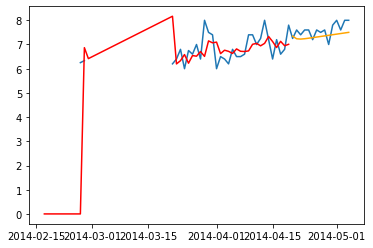

Test MSE: 0.6536246301817742 			for 2, 0 and 0


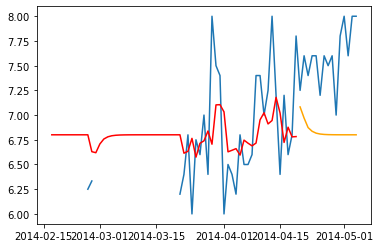

Test MSE: 0.653784317984875 			for 2, 0 and 1


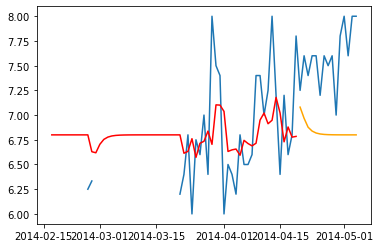

Test MSE: 0.6540170694778411 			for 2, 0 and 2


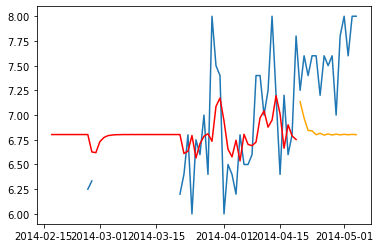

Test MSE: 0.13799562587892525 			for 2, 1 and 0


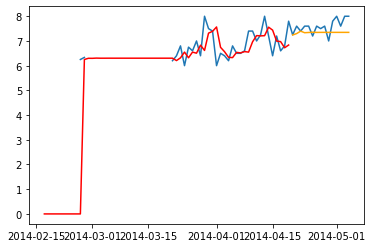

Test MSE: 0.37499834421065736 			for 2, 1 and 1


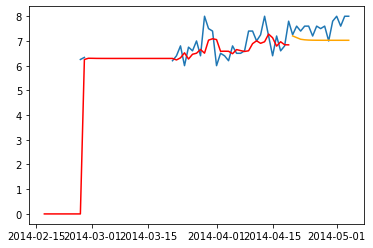

Test MSE: 0.36368512077328397 			for 2, 1 and 2


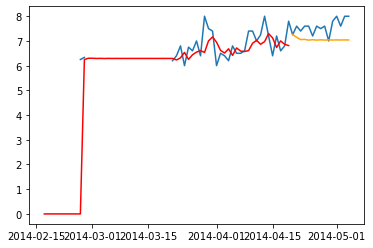

Test MSE: 11.71501782206438 			for 2, 2 and 0


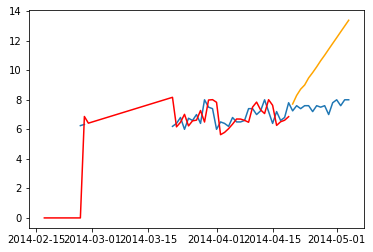

Test MSE: 0.06101042177970197 			for 2, 2 and 1


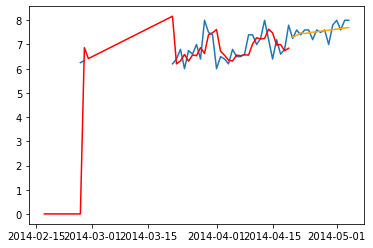

Test MSE: 0.07295287547595189 			for 2, 2 and 2


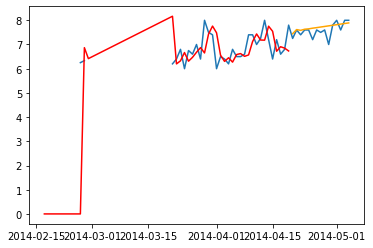

Test MSE: 0.653857170232651 			for 3, 0 and 0


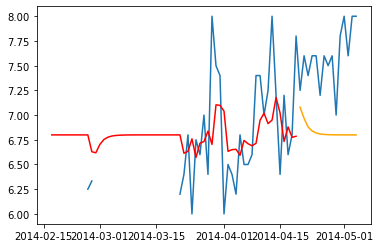

Test MSE: 0.6538644012361876 			for 3, 0 and 1


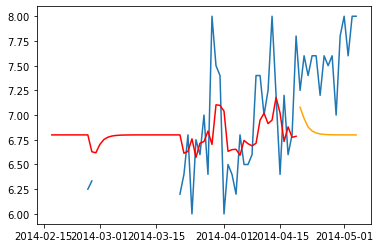

Test MSE: 0.5256833733425418 			for 3, 0 and 2


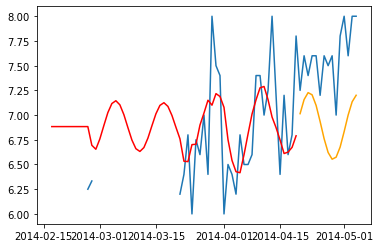

Test MSE: 0.17050235782456483 			for 3, 1 and 0


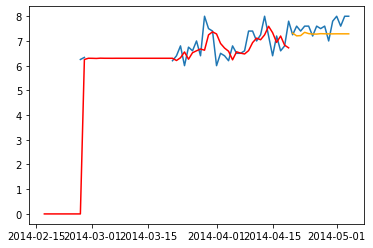

Test MSE: 0.3752187179011784 			for 3, 1 and 1


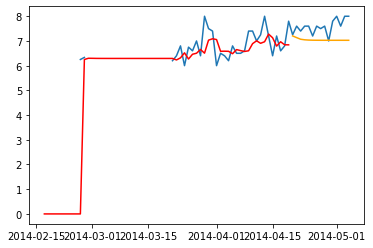

Test MSE: 0.36092255954245617 			for 3, 1 and 2


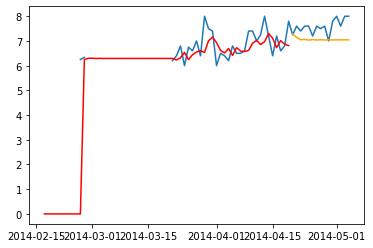

Test MSE: 7.740036322328504 			for 3, 2 and 0


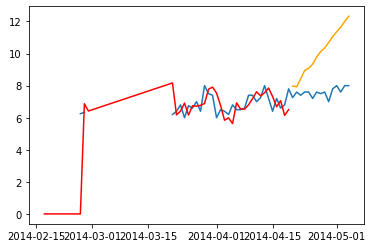

Test MSE: 0.07131311434195445 			for 3, 2 and 1


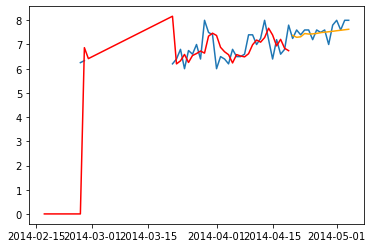

Test MSE: 0.06811566116945127 			for 3, 2 and 2


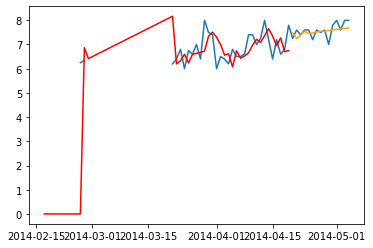

Test MSE: 0.6204873443189418 			for 0, 0 and 0


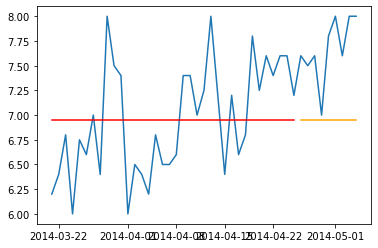

Test MSE: 0.6213055698056977 			for 0, 0 and 1


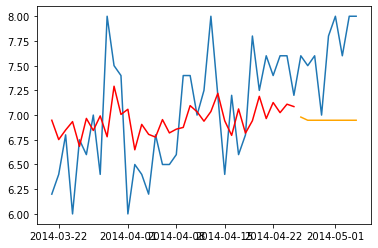

Test MSE: 0.6201330986926308 			for 0, 0 and 2


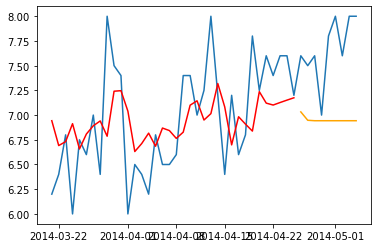

Test MSE: 0.3211111111111117 			for 0, 1 and 0


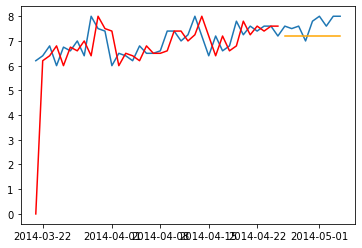

Test MSE: 0.17206217078833103 			for 0, 1 and 1


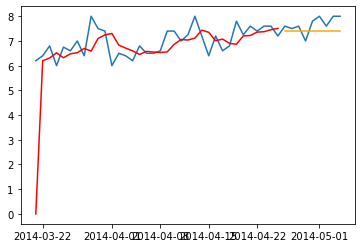

Test MSE: 0.21110985068361804 			for 0, 1 and 2


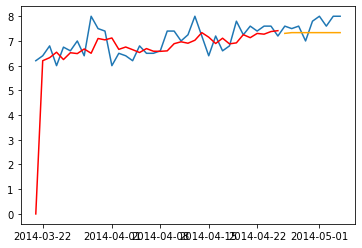

Test MSE: 7.663333334287568 			for 0, 2 and 0


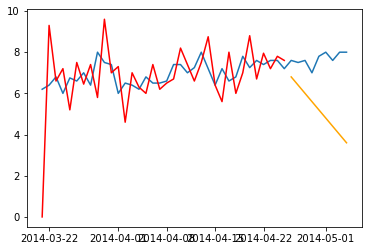

Test MSE: 0.1844215130714677 			for 0, 2 and 1


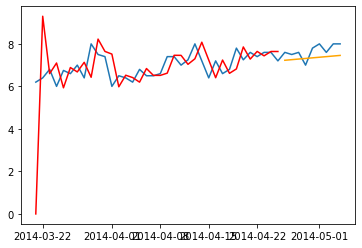

Test MSE: 0.07720755312735066 			for 0, 2 and 2


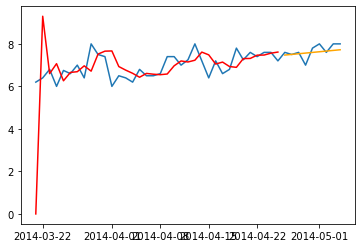

Test MSE: 0.6117909461451805 			for 1, 0 and 0


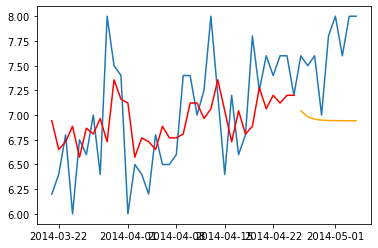

Test MSE: 0.5634167565931091 			for 1, 0 and 1


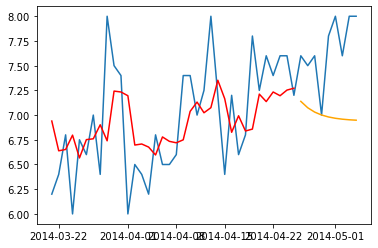

Test MSE: 0.5746169452576265 			for 1, 0 and 2


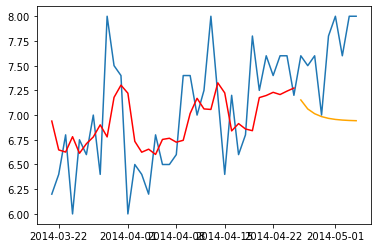

Test MSE: 0.21862596317427255 			for 1, 1 and 0


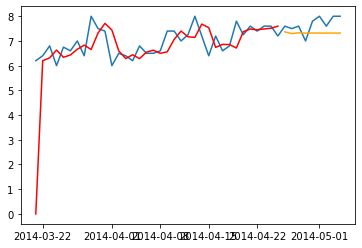

Test MSE: 0.2440748765206373 			for 1, 1 and 1


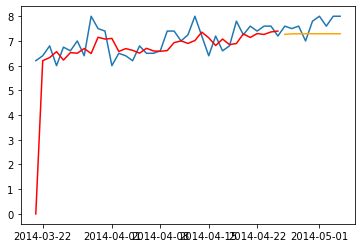

Test MSE: 0.2697134090943741 			for 1, 1 and 2


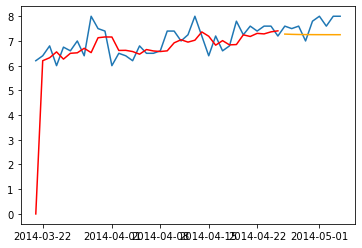

Test MSE: 3.361461643364608 			for 1, 2 and 0


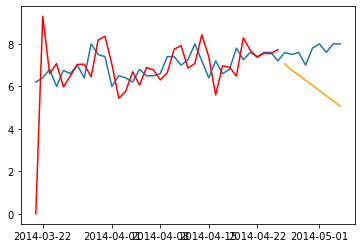

Test MSE: 0.10780391578943009 			for 1, 2 and 1


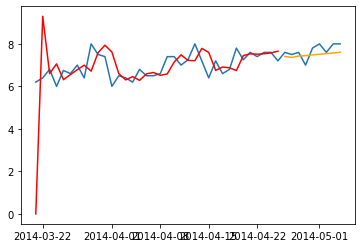

Test MSE: 0.09463468312737314 			for 1, 2 and 2


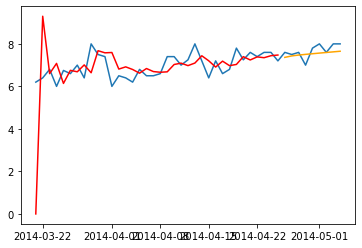

Test MSE: 0.5782845671412868 			for 2, 0 and 0


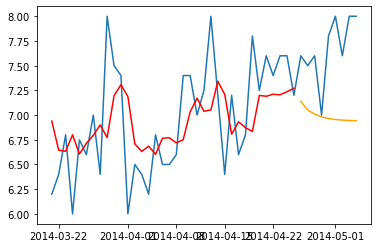

Test MSE: 0.5708733258617751 			for 2, 0 and 1


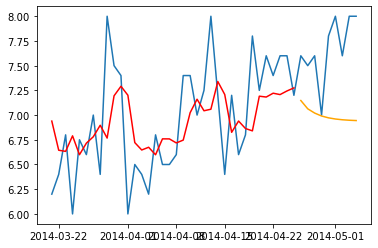

Test MSE: 0.5770823496076412 			for 2, 0 and 2


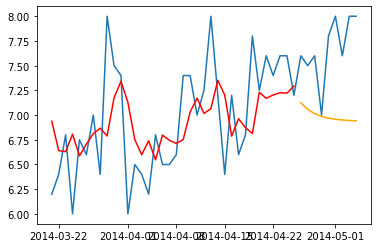

Test MSE: 0.1896433147414237 			for 2, 1 and 0


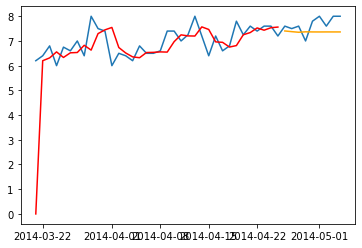

Test MSE: 0.27374637094308296 			for 2, 1 and 1


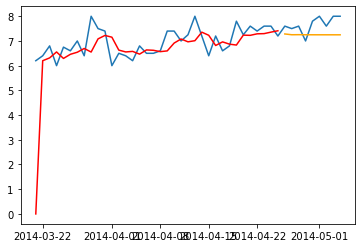

Test MSE: 0.2657768036408072 			for 2, 1 and 2


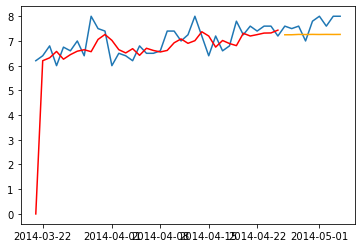

Test MSE: 1.389834008436781 			for 2, 2 and 0


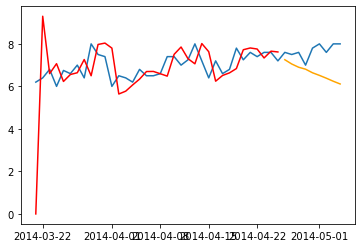

Test MSE: 0.09264724785107589 			for 2, 2 and 1


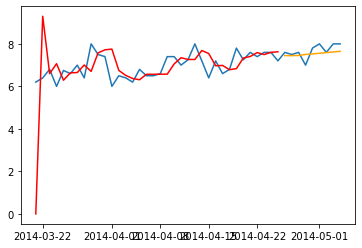

Test MSE: 0.11298633794076898 			for 2, 2 and 2


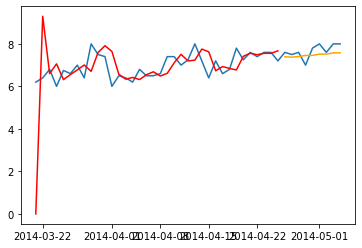

Test MSE: 0.5697278720357407 			for 3, 0 and 0


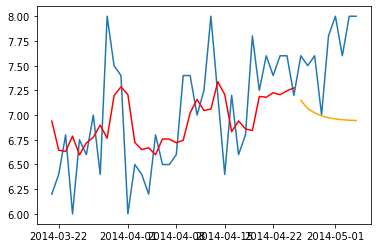

Test MSE: 0.5694946377313828 			for 3, 0 and 1


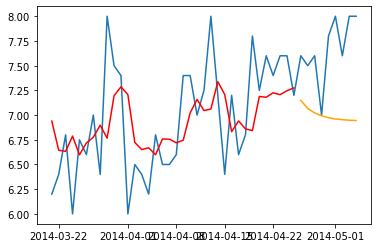

Test MSE: 0.5522420003583073 			for 3, 0 and 2


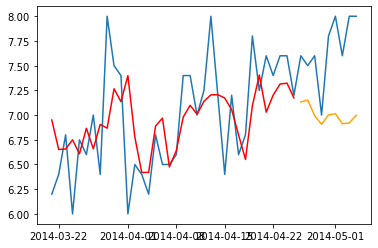

Test MSE: 0.1778163862840757 			for 3, 1 and 0


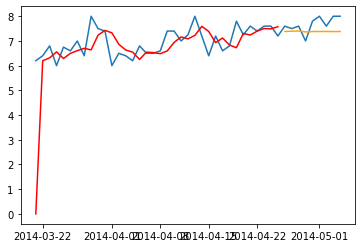

Test MSE: 0.274064352380814 			for 3, 1 and 1


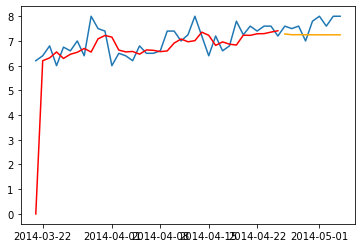

Test MSE: 0.27193342051615316 			for 3, 1 and 2


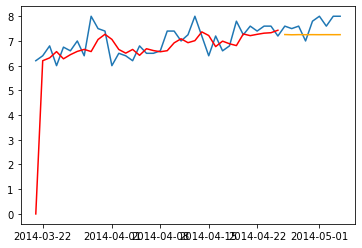

Test MSE: 0.8872440473643246 			for 3, 2 and 0


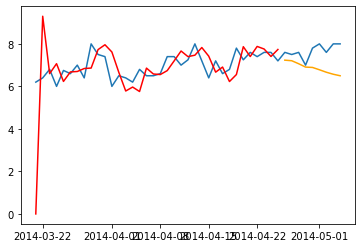

Test MSE: 0.0816173788179037 			for 3, 2 and 1


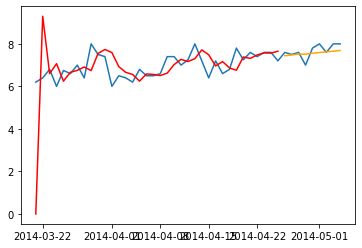

Test MSE: 0.08611575276691151 			for 3, 2 and 2


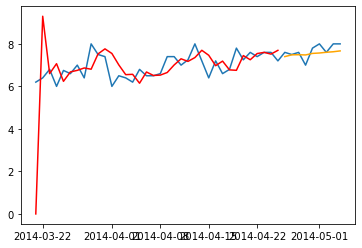

Test MSE: 0.6239352955458067 			for 0, 0 and 0


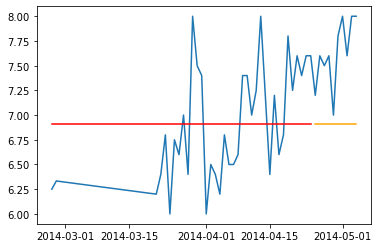

Test MSE: 0.6176516118648271 			for 0, 0 and 1


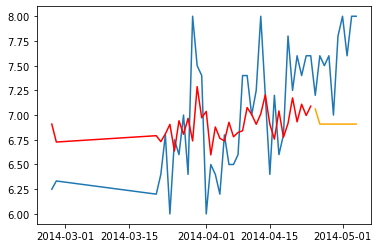

Test MSE: 0.6014008626130402 			for 0, 0 and 2


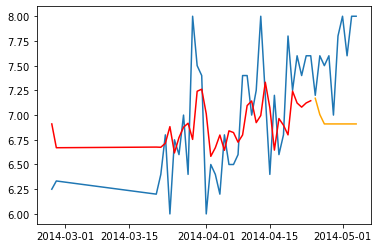

Test MSE: 0.10500000000000001 			for 0, 1 and 0


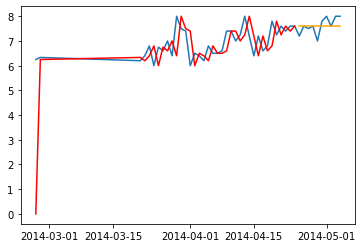

Test MSE: 0.11560735210094841 			for 0, 1 and 1


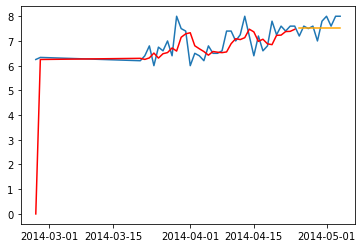

Test MSE: 0.13966148330242883 			for 0, 1 and 2


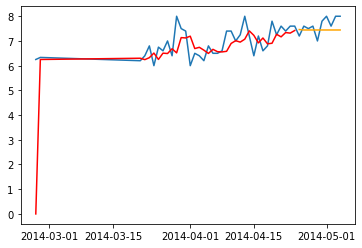

Test MSE: 0.10499999997933744 			for 0, 2 and 0


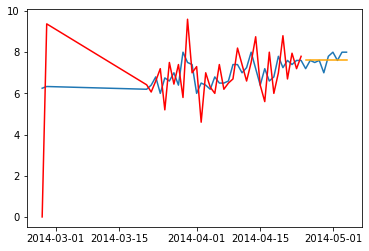

Test MSE: 0.09989118560952744 			for 0, 2 and 1


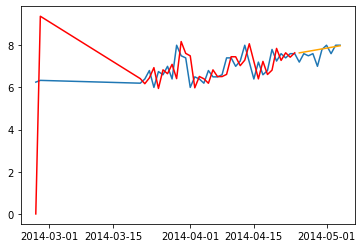

Test MSE: 0.09201519884831344 			for 0, 2 and 2


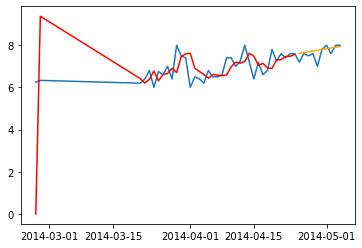

Test MSE: 0.5867603478265423 			for 1, 0 and 0


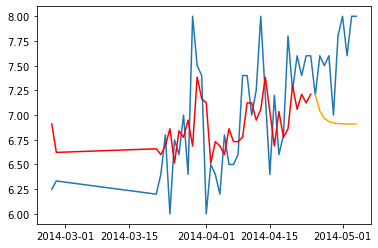

Test MSE: 0.4960313640274113 			for 1, 0 and 1


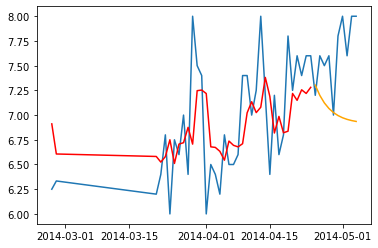

Test MSE: 0.5169845354813034 			for 1, 0 and 2


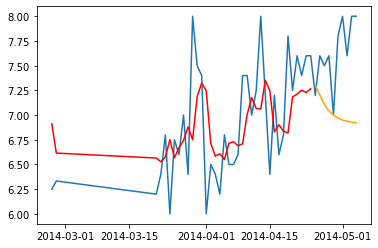

Test MSE: 0.10500000000000001 			for 1, 1 and 0


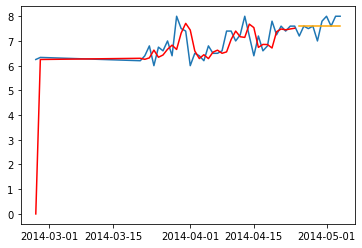

Test MSE: 0.16876808813494265 			for 1, 1 and 1


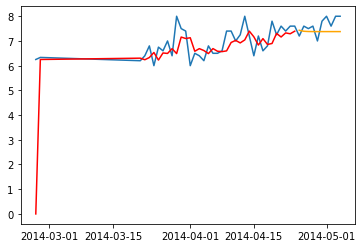

Test MSE: 0.18784480127204714 			for 1, 1 and 2


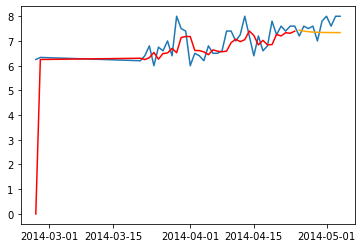

Test MSE: 0.24698204476960495 			for 1, 2 and 0


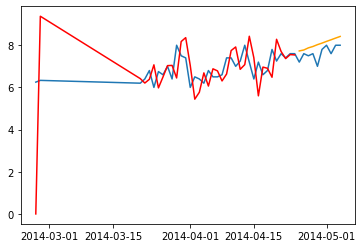

Test MSE: 0.10421301572846826 			for 1, 2 and 1


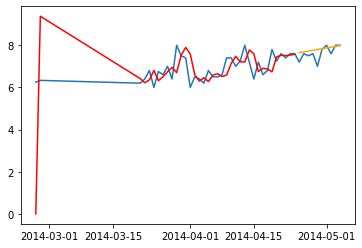

Test MSE: 0.0799948970424992 			for 1, 2 and 2


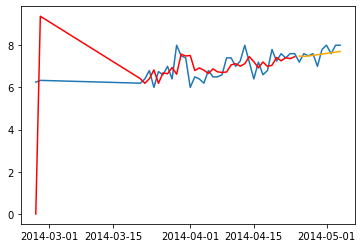

Test MSE: 0.5240816693631705 			for 2, 0 and 0


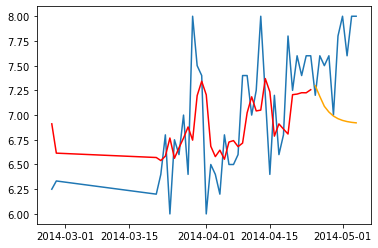

Test MSE: 0.5097453370147351 			for 2, 0 and 1


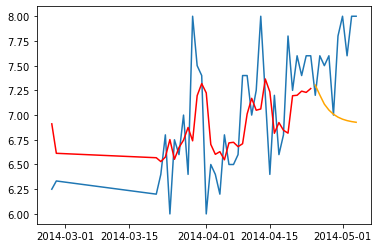

Test MSE: 0.5078367928032799 			for 2, 0 and 2


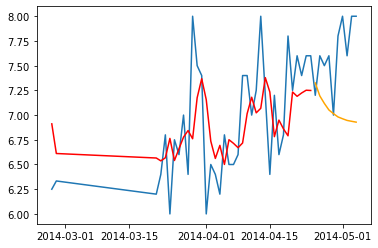

Test MSE: 0.10571530689940697 			for 2, 1 and 0


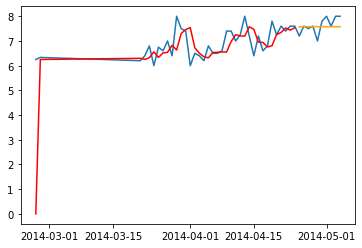

Test MSE: 0.1913554702221368 			for 2, 1 and 1


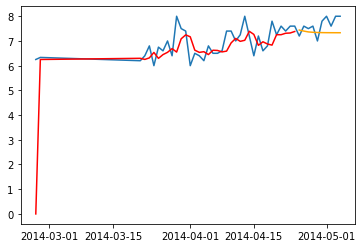

Test MSE: 0.18371150481386084 			for 2, 1 and 2


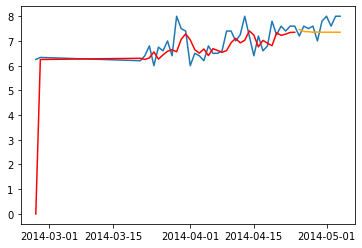

Test MSE: 0.10827371729688817 			for 2, 2 and 0


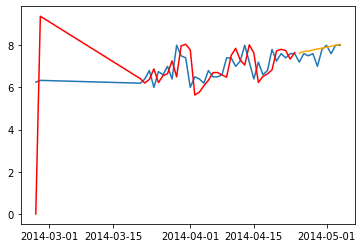

Test MSE: 0.09861301093321097 			for 2, 2 and 1


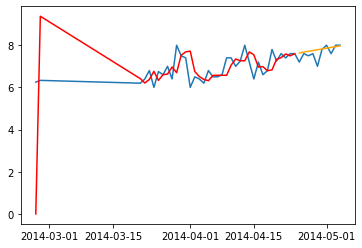

Test MSE: 0.10917739090319803 			for 2, 2 and 2


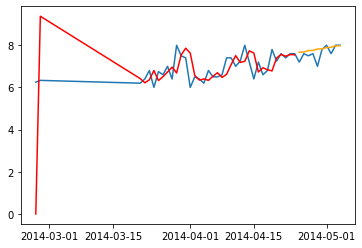

Test MSE: 0.5111790215591169 			for 3, 0 and 0


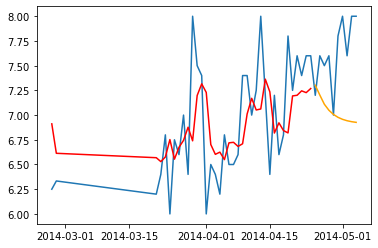

Test MSE: 0.5091226346181609 			for 3, 0 and 1


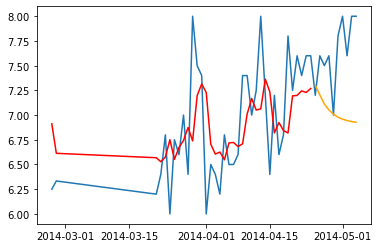

Test MSE: 0.5084106473949717 			for 3, 0 and 2


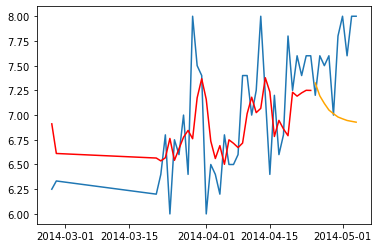

Test MSE: 0.10805757404479284 			for 3, 1 and 0


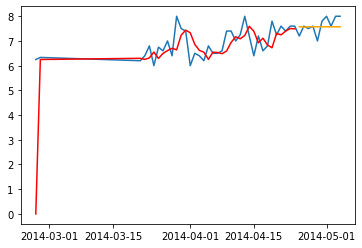

Test MSE: 0.1914061245279568 			for 3, 1 and 1


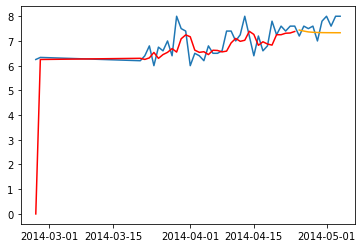

Test MSE: 0.18843966351392066 			for 3, 1 and 2


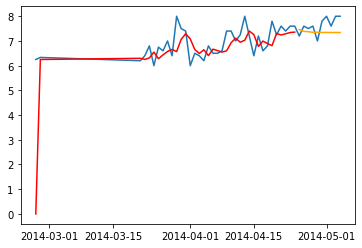

Test MSE: 0.17805466682312274 			for 3, 2 and 0


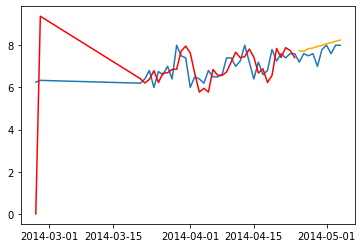

Test MSE: 0.1021862527646579 			for 3, 2 and 1


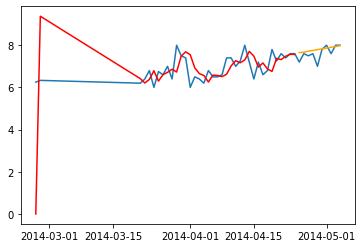

Test MSE: 0.11247457956924409 			for 3, 2 and 2


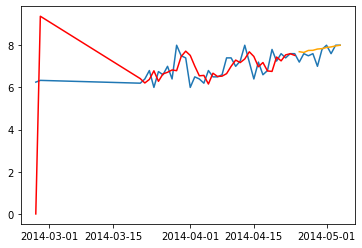

In [17]:
pdq_results = do_experiment_ARIMA_find_pdq_values(mood, p_values, d_values, q_values)
pdq_results.sort_values('mse', inplace = True)
pdq_results = pdq_results.reset_index()

pdq_results_cutoff = do_experiment_ARIMA_find_pdq_values(mood_cutoff, p_values, d_values, q_values)
pdq_results_cutoff.sort_values('mse', inplace = True)
pdq_results_cutoff = pdq_results_cutoff.reset_index()

pdq_results_dropna = do_experiment_ARIMA_find_pdq_values(mood_dropna, p_values, d_values, q_values)
pdq_results_dropna.sort_values('mse', inplace = True)
pdq_results_dropna = pdq_results_dropna.reset_index()

In [18]:
dfs_pdq = [pdq_results, pdq_results_cutoff, pdq_results_dropna]

df_pdq = pd.concat(dfs_pdq, axis=1, keys=range(1, len(dfs_pdq) + 1))
df_pdq.columns = df_pdq.columns.map('{0[1]}{0[0]}'.format)
df_pdq

index1  p1  d1  q1       mse1  index2  p2  d2  q2      mse2  index3  p3  \
0       25   2   2   1   0.061010       8   0   2   2  0.077208      17   1   
1       35   3   2   2   0.068116      34   3   2   1  0.081617       8   0   
2       34   3   2   1   0.071313      35   3   2   2  0.086116      25   2   
3       16   1   2   1   0.072469      25   2   2   1  0.092647       7   0   
4       26   2   2   2   0.072953      17   1   2   2  0.094635      34   3   
5       12   1   1   0   0.082200      16   1   2   1  0.107804      16   1   
6       17   1   2   2   0.118070      26   2   2   2  0.112986       6   0   
7        3   0   1   0   0.127500       4   0   1   1  0.172062       3   0   
8       21   2   1   0   0.137996      30   3   1   0  0.177816      12   1   
9        8   0   2   2   0.147938       7   0   2   1  0.184422      21   2   
10      30   3   1   0   0.170502      21   2   1   0  0.189643      30   3   
11       7   0   2   1   0.265878       5   0   1   2  0.211110      24   2   
12       4   0   1   1   0.312936      12   1   1   0  0.218626      26   2   
13       5   0   1   2   0.351091      13   1   1   1  0.244075      35   3   
14      32   3   1   2   0.360923      23   2   1   2  0.265777       4   0   
15      23   2   1   2   0.363685      14   1   1   2  0.269713       5   0   
16      13   1   1   1   0.365524      32   3   1   2  0.271933      13   1   
17      22   2   1   1   0.374998      22   2   1   1  0.273746      33   3   
18      31   3   1   1   0.375219      31   3   1   1  0.274064      23   2   
19      14   1   1   2   0.377054       3   0   1   0  0.321111      14   1   
20      29   3   0   2   0.525683      29   3   0   2  0.552242      32   3   
21      18   2   0   0   0.653625      10   1   0   1  0.563417      22   2   
22      19   2   0   1   0.653784      28   3   0   1  0.569495      31   3   
23      27   3   0   0   0.653857      27   3   0   0  0.569728      15   1   
24      28   3   0   1   0.653864      19   2   0   1  0.570873      10   1   
25      20   2   0   2   0.654017      11   1   0   2  0.574617      20   2   
26      10   1   0   1   0.654448      20   2   0   2  0.577082      29   3   
27       2   0   0   2   0.655108      18   2   0   0  0.578285      28   3   
28       9   1   0   0   0.655513       9   1   0   0  0.611791      19   2   
29      11   1   0   2   0.657835       2   0   0   2  0.620133      27   3   
30       1   0   0   1   0.659963       0   0   0   0  0.620487      11   1   
31       0   0   0   0   0.665948       1   0   0   1  0.621306      18   2   
32      33   3   2   0   7.740036      33   3   2   0  0.887244       9   1   
33      24   2   2   0  11.715018      24   2   2   0  1.389834       2   0   
34      15   1   2   0  39.064554      15   1   2   0  3.361462       1   0   
35       6   0   2   0  84.867500       6   0   2   0  7.663333       0   0   

    d3  q3      mse3  
0    2   2  0.079995  
1    2   2  0.092015  
2    2   1  0.098613  
3    2   1  0.099891  
4    2   1  0.102186  
5    2   1  0.104213  
6    2   0  0.105000  
7    1   0  0.105000  
8    1   0  0.105000  
9    1   0  0.105715  
10   1   0  0.108058  
11   2   0  0.108274  
12   2   2  0.109177  
13   2   2  0.112475  
14   1   1  0.115607  
15   1   2  0.139661  
16   1   1  0.168768  
17   2   0  0.178055  
18   1   2  0.183712  
19   1   2  0.187845  
20   1   2  0.188440  
21   1   1  0.191355  
22   1   1  0.191406  
23   2   0  0.246982  
24   0   1  0.496031  
25   0   2  0.507837  
26   0   2  0.508411  
27   0   1  0.509123  
28   0   1  0.509745  
29   0   0  0.511179  
30   0   2  0.516985  
31   0   0  0.524082  
32   0   0  0.586760  
33   0   2  0.601401  
34   0   1  0.617652  
35   0   0  0.623935

Weird results to me, I would not have expected that the full range (with a very long gap between the first days and the rest of the days) would perform better than the cutoff-range or the ranges with NaN dropped.

So it seems like it's not necessary to cut off the period or remove aNs? We still do a further analysis of this though cause i think it's weird.

Test MSE: 0.06101042177970197 	for 2, 2 and 1


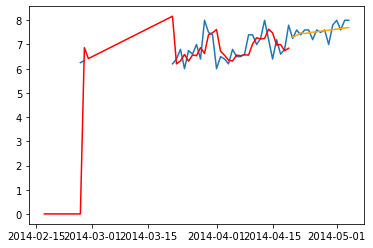

Test MSE: 0.07720755312735066 	for 0, 2 and 2


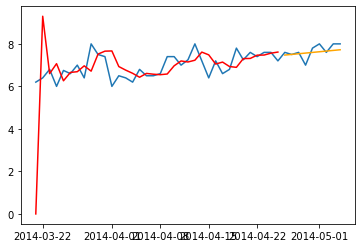

Test MSE: 0.0799948970424992 	for 1, 2 and 2


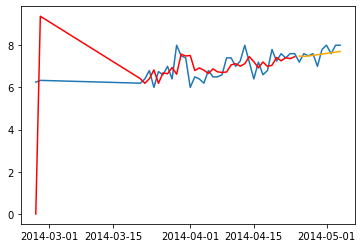

In [19]:
perform_ARIMA(mood, (2,2,1))
perform_ARIMA(mood_cutoff, (0,2,2))
perform_ARIMA(mood_dropna, (1,2,2))

In [20]:
train, test = get_train_set_set(mood, perc_train)
train_cutoff, test_cutoff = get_train_set_set(mood_cutoff, perc_train)
train_dropna, test_dropna = get_train_set_set(mood_dropna, perc_train)
print(f'Full range has {int(train.count())} non-NaN training values (out of {int(len(train))}) and {int(test.count())} test values')
print(f'Cutoff range has {int(train_cutoff.count())} non-NaN training values (out of {int(len(train_cutoff))}) and {int(test_cutoff.count())} test values')
print(f'Dropna range has {int(train_dropna.count())} non-NaN training values (out of {int(len(train_dropna))}) and {int(test_dropna.count())} test values')

Full range has 32 non-NaN training values (out of 62) and 15 test values
Cutoff range has 36 non-NaN training values (out of 36) and 9 test values
Dropna range has 37 non-NaN training values (out of 37) and 10 test values


The full range has less values to train on and more values to test on than the cutoff/dropna range. Makes it even weirder for me that it performs better. 

But okay, this might not even be a big problem. Let's see how many persons have missing mood data. 

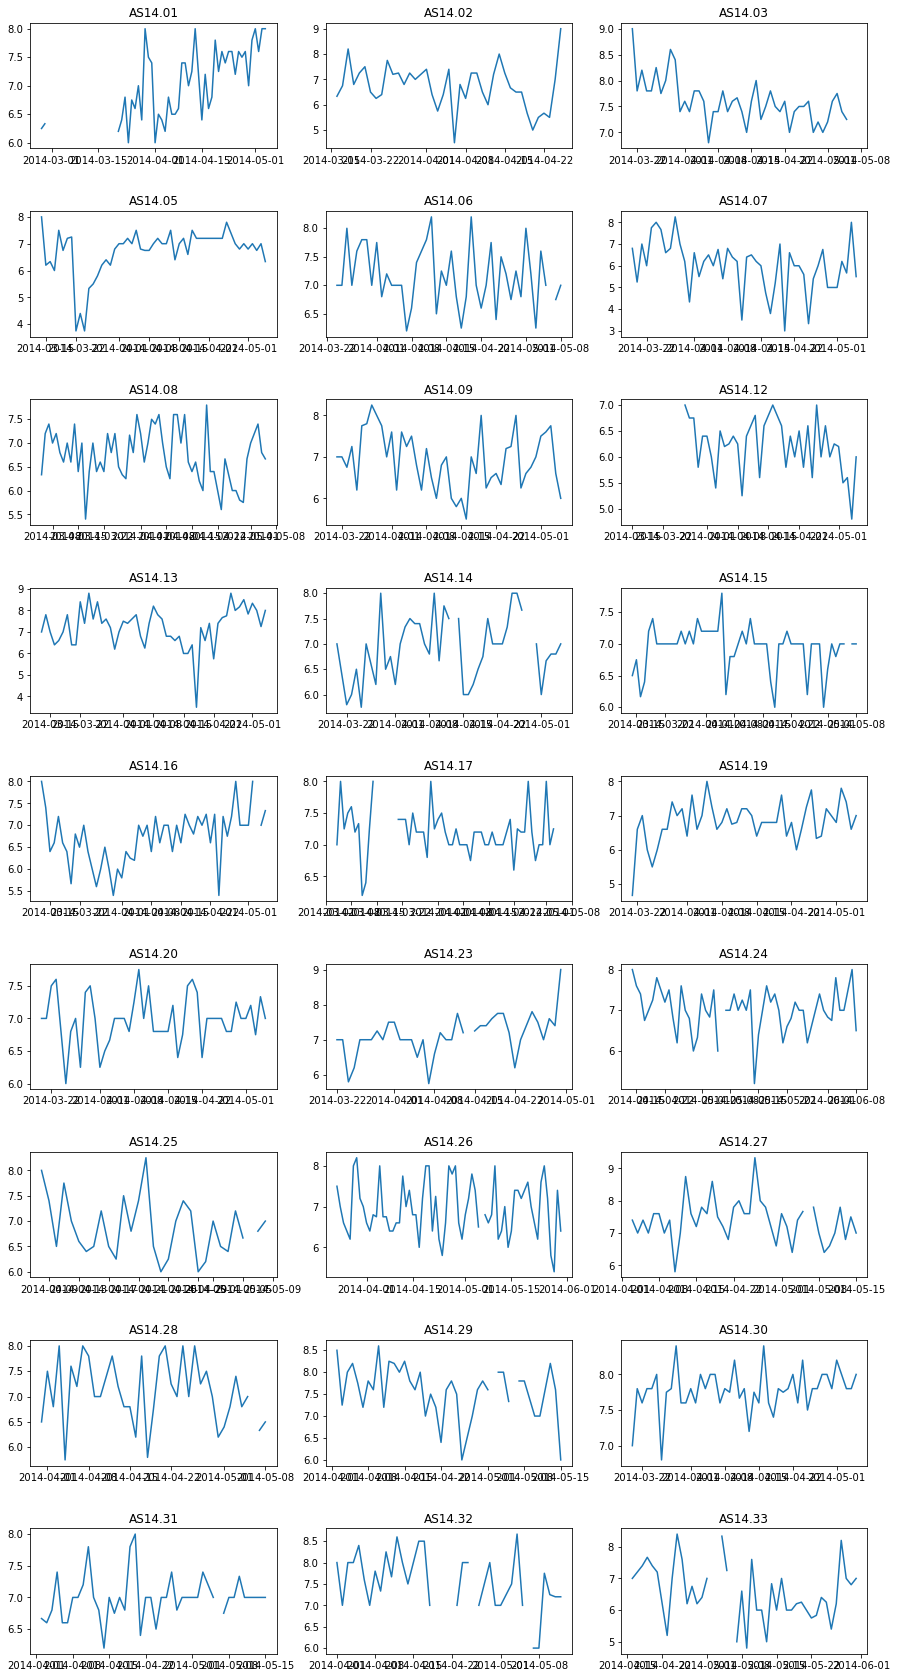

In [21]:
fig, axes = plt.subplots(nrows=int(np.ceil(len(df.id.unique()) / 3)), ncols=3)
fig.set_figheight(30)
fig.set_figwidth(15)
fig.subplots_adjust(hspace=0.5)

# Plot mood for each person
for ax, person in zip(axes.flatten(), df.id.unique()):
    mood = getPersonMoodArimaSet(person)
    ax.set(title=person)
    ax.plot(mood)

Not a lot, so should not be a problem. We can probably just use ARIMA onthe full set. For reference, the following persons have some big chunks of missing data:
- AS14.01 in the beginning
- AS14.17 in the beginning
- AS14.32 in the middle

Furthermore, some persons have small gaps in the end at the test set. Will look into this later.

For the sake of completeness, we will try all 2 sets on each person and note the differences between the best scores.

In [22]:
df_results = pd.DataFrame(columns=df_pdq.columns[0:10], index=df.id.unique()) # init

# Do p,d,q experiment for each person, for each dataset
for person in df.id.unique():
    
    # Get mood set
    mood = getPersonMoodArimaSet(person)
    
    # Drop NaN mood set
    mood_dropna = mood.dropna()
    
    # Results for complete set
    pdq_results = do_experiment_ARIMA_find_pdq_values(mood, p_values, d_values, q_values, doPrint=False)
    pdq_results.sort_values('mse', inplace = True)
    pdq_results = pdq_results.reset_index()

    # Results for set with dropped NaN
    pdq_results_dropna = do_experiment_ARIMA_find_pdq_values(mood_dropna, p_values, d_values, q_values, doPrint=False)
    pdq_results_dropna.sort_values('mse', inplace = True)
    pdq_results_dropna = pdq_results_dropna.reset_index()
    
    # Get best results
    dfs_pdq = [pdq_results, pdq_results_dropna]
    df_pdq = pd.concat(dfs_pdq, axis=1, keys=range(1, len(dfs_pdq) + 1))
    df_pdq.columns = df_pdq.columns.map('{0[1]}{0[0]}'.format)

    # Save best orders and their mse 
    df_results.loc[person] = df_pdq.loc[0]

In [23]:
df_results.to_csv('results/arima_results.csv')

In [24]:
df_results

index1 p1 d1 q1       mse1 index2 p2 d2 q2       mse2
AS14.01     25  2  2  1  0.0610104     17  1  2  2  0.0799949
AS14.02      3  0  1  0     1.1228      3  0  1  0    1.45679
AS14.03      3  0  1  0  0.0610741     23  2  1  2  0.0668982
AS14.05      7  0  2  1   0.077903     23  2  1  2   0.104804
AS14.06     30  3  1  0    0.20556      4  0  1  1   0.234177
AS14.07      9  1  0  0    0.81074      9  1  0  0    0.81074
AS14.08     20  2  0  2   0.454236     31  3  1  1   0.331808
AS14.09      0  0  0  0   0.342652     20  2  0  2   0.339692
AS14.12     12  1  1  0   0.261748     22  2  1  1   0.409324
AS14.13      0  0  0  0   0.876994      7  0  2  1   0.490899
AS14.14     20  2  0  2   0.337919     32  3  1  2   0.369214
AS14.15      4  0  1  1  0.0953342      4  0  1  1  0.0911053
AS14.16     26  2  2  2   0.330377     33  3  2  0   0.380647
AS14.17      1  0  0  1   0.140164     29  3  0  2   0.134951
AS14.19     26  2  2  2   0.262574     34  3  2  1   0.233638
AS14.20      5  0  1  2  0.0679068     16  1  2  1  0.0356109
AS14.23     17  1  2  2   0.357352     17  1  2  2   0.467603
AS14.24     27  3  0  0    0.20302     29  3  0  2   0.210726
AS14.25     19  2  0  1   0.336726     33  3  2  0  0.0483159
AS14.26     29  3  0  2   0.461676     29  3  0  2   0.461527
AS14.27      1  0  0  1   0.370881     30  3  1  0   0.285785
AS14.28      0  0  0  0   0.286031      3  0  1  0   0.241806
AS14.29      2  0  0  2   0.265299     16  1  2  1   0.345917
AS14.30     33  3  2  0  0.0355086     25  2  2  1  0.0252213
AS14.31     30  3  1  0  0.0234381     32  3  1  2  0.0131668
AS14.32     17  1  2  2   0.589611     31  3  1  1   0.634426
AS14.33     30  3  1  0   0.455984     19  2  0  1   0.542987

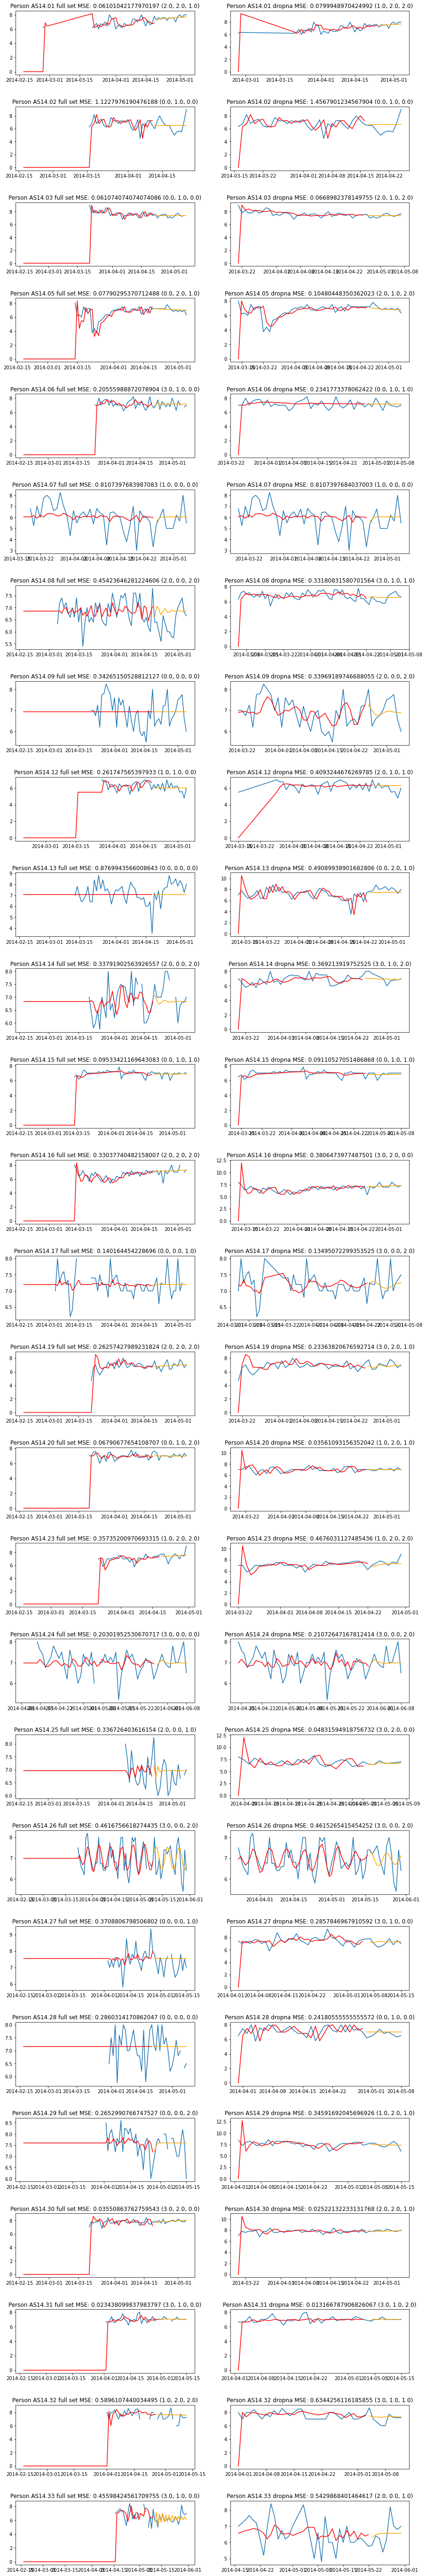

In [25]:
# Plotting stuff
fig, axes = plt.subplots(nrows=int(len(df.id.unique())), ncols=2)
fig.set_figheight(100)
fig.set_figwidth(15)
fig.subplots_adjust(hspace=0.5)
axs = axes.flatten()

# Plot arima fitted values and forecasting for each person
for i, person in enumerate(df.id.unique()):
    
    # Get mood set
    mood = getPersonMoodArimaSet(person)

    # Drop NaN mood set
    mood_dropna = mood.dropna()
    
    # Get training and test sets
    train, test = get_train_set_set(mood, perc_train)
    train_dropna, test_dropna = get_train_set_set(mood_dropna, perc_train)
    
    # Get arima orders
    pdq = (df_results.loc[person].p1, df_results.loc[person].d1, df_results.loc[person].q1)
    pdq_dropna = (df_results.loc[person].p2, df_results.loc[person].d2, df_results.loc[person].q2)
    
    # Train the models
    model = ARIMA(train, order=pdq)
    model_fit = model.fit()
    model_dropna = ARIMA(train_dropna, order=pdq_dropna)
    model_fit_dropna = model_dropna.fit()

    # Forecast and check accuracy
    forecast = model_fit.forecast(len(test))
    mse = mean_squared_error(test, forecast)
    forecast_dropna = model_fit_dropna.forecast(len(test_dropna))
    mse_dropna = mean_squared_error(test_dropna, forecast_dropna)

    # Make axes
    ax = axs[i*2]
    ax_dropna = axs[i*2+1]
    
    # Plot full range
    ax.set_title(f'Person {person} full set MSE: {mse} {pdq}')
    ax.plot(mood)
    ax.plot(model_fit.fittedvalues, color='red')
    ax.plot(test.index, forecast, color='orange')
    
    # Plot dropped NaN
    ax_dropna.set_title(f'Person {person} dropna MSE: {mse_dropna} {pdq_dropna}')
    ax_dropna.plot(mood_dropna)
    ax_dropna.plot(model_fit_dropna.fittedvalues, color='red')
    ax_dropna.plot(test_dropna.index, forecast_dropna, color='orange')

In [ ]:
# todo: analyse effect of test set size. I do not think it's logical that full set performs consistenly better?